# Contexto y formulación del problema


Problema (aprendizaje supervisado)

Dado un conjunto de imágenes de hojas de tomate etiquetadas por clase (enfermedad/estado), entrenar un modelo que prediga la clase de una imagen nueva.

* **Tipo de tarea:** Clasificación multiclase (10 clases).
* **Variable objetivo (y):** etiqueta de clase = nombre de la subcarpeta (p. ej., Tomato___Late_blight).
* **Variables de entrada (X):** píxeles de la imagen (tras preprocesamiento) + transformaciones (augmentations).

**Tomadores de decisión (beneficiarios)**

* Productores agrícolas / técnicos de campo: apoyo a diagnóstico temprano.

* Encargados de fitosanidad: priorización de tratamientos, monitoreo y control.

* Investigadores/agronomía: cuantificación de incidencia por zona/temporada.

**Por qué es desafiante computacionalmente**

Variabilidad por iluminación, ángulo, fondo, escala, daño parcial.

* Patrones visuales sutiles y no lineales entre enfermedades.

* Posible desbalance de clases y “intra-clase” alta (misma enfermedad con apariencias distintas).

* Enfoques tradicionales (reglas explícitas) son frágiles ante ruido/variabilidad.

Esto calza con “Contexto y formulación” del documento.

In [ ]:
# ============================================
# 1
# Descargar SOLO una carpeta desde GitHub en Google Colab (Sparse Checkout)
# Deja la carpeta lista en /content/DataImg
# ============================================

import os
import shutil
import subprocess

# 1) Variables
REPO_URL = "https://github.com/GuidoRiosCiaffaroni/Machine_Learning_II.git"
FOLDER_NAME = "DataImg/TomatoDataset_ready"
TMP_DIR = "/content/repo_temporal"

# 2) Helpers
def run(cmd, cwd=None):
    print(f"\n$ {cmd}")
    subprocess.check_call(cmd, shell=True, cwd=cwd)

def get_default_branch(repo_url):
    # Detecta rama por defecto (main / master)
    try:
        out = subprocess.check_output(
            f'git ls-remote --symref {repo_url} HEAD',
            shell=True,
            text=True
        )
        for line in out.splitlines():
            if line.startswith("ref:"):
                return line.split("refs/heads/")[-1].split("\t")[0].strip()
    except Exception:
        pass
    return "main"

# 3) Preparación: limpiar previos
shutil.rmtree(TMP_DIR, ignore_errors=True)
shutil.rmtree(f"/content/{FOLDER_NAME}", ignore_errors=True)
os.makedirs(TMP_DIR, exist_ok=True)

# 4) Detectar rama por defecto
BRANCH = get_default_branch(REPO_URL)
print(f" Rama detectada: {BRANCH}")

# 5) Inicializar repo temporal y configurar sparse checkout
run("git init", cwd=TMP_DIR)
run(f'git remote add origin "{REPO_URL}"', cwd=TMP_DIR)
run("git sparse-checkout init --cone", cwd=TMP_DIR)
run(f'git sparse-checkout set "{FOLDER_NAME}"', cwd=TMP_DIR)

# 6) Descargar solo esa carpeta
run(f'git pull --depth 1 origin "{BRANCH}"', cwd=TMP_DIR)

# 7) Mover a /content y limpiar
src_path = os.path.join(TMP_DIR, FOLDER_NAME)
dst_path = os.path.join("/content", FOLDER_NAME)

if not os.path.exists(src_path):
    raise FileNotFoundError(
        f"No se encontró la carpeta '{FOLDER_NAME}' en el repo. "
        f"Revisa que exista en la rama '{BRANCH}'."
    )

shutil.move(src_path, dst_path)
shutil.rmtree(TMP_DIR, ignore_errors=True)

print(f"\n Proceso finalizado. Carpeta lista en: {dst_path}")
print(" Archivos (primeros 30):")
print(os.listdir(dst_path)[:30])


 Rama detectada: main

$ git init

$ git remote add origin "https://github.com/GuidoRiosCiaffaroni/Machine_Learning_II.git"

$ git sparse-checkout init --cone

$ git sparse-checkout set "DataImg/TomatoDataset_ready"

$ git pull --depth 1 origin "main"

 Proceso finalizado. Carpeta lista en: /content/DataImg/TomatoDataset_ready
 Archivos (primeros 30):
['Tomato___Late_blight', 'Tomato___Septoria_leaf_spot', 'Tomato___Tomato_mosaic_virus', 'Tomato___Target_Spot', 'Tomato___Leaf_Mold', 'Tomato___Bacterial_spot', 'Tomato___healthy', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Early_blight', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus']


# Bloque 1 — Configuración inicial y reproducibilidad

### Objetivo general
Este bloque inicial prepara el entorno de trabajo para ejecutar un experimento de *Deep Learning* en Google Colab de forma **reproducible**, es decir, buscando que los resultados (por ejemplo, métricas y comportamiento del entrenamiento) sean lo más consistentes posible entre ejecuciones.

---

### Paso 1: Importación de librerías esenciales
Se importan módulos que cumplen funciones específicas dentro del flujo de trabajo:

- **`os`**: permite interactuar con el sistema de archivos (rutas, carpetas, nombres de archivos).  
  *Se utiliza después para localizar el dataset y manipular directorios.*

- **`random`**: generador de números pseudoaleatorios estándar de Python.  
  *Se usa para controlar aleatoriedad de operaciones básicas como mezclas.*

- **`glob`**: búsqueda de archivos por patrones (por ejemplo `*.jpg`, `*.png`).  
  *Se usa típicamente para listar imágenes dentro de carpetas.*

- **`numpy`**: librería fundamental para computación numérica.  
  *Se usa para arreglos, etiquetas, cálculos estadísticos y transformaciones.*

- **`tensorflow`**: framework principal para construir, entrenar y evaluar modelos de redes neuronales.  
  *En este proyecto se utiliza para EfficientNet, pipelines `tf.data`, entrenamiento y predicción.*

---

### Paso 2: Definición de una semilla (`SEED`)
Se define un valor fijo de semilla (por ejemplo, 42) para establecer un punto de inicio común en la generación de números pseudoaleatorios.

**¿Por qué es importante?**  
En *Machine Learning* y *Deep Learning* existen múltiples fuentes de aleatoriedad, por ejemplo:
- inicialización de pesos de la red,
- mezclado (*shuffle*) de datos,
- transformaciones aleatorias en *data augmentation*,
- partición de datos en entrenamiento/validación/test.

Fijar la semilla ayuda a que esas operaciones sean más consistentes entre ejecuciones.

---

### Paso 3: Fijar la semilla en distintos generadores aleatorios
Se fija la semilla en **tres niveles**, porque cada librería maneja su propia aleatoriedad:

- **Python (`random`)**: controla aleatoriedad del módulo estándar.
- **NumPy (`numpy.random`)**: controla aleatoriedad de operaciones numéricas y muestreos.
- **TensorFlow (`tf.random`)**: controla aleatoriedad interna del framework (inicializaciones, operaciones estocásticas, etc.).

**Nota importante (limitación real):**  
Incluso fijando semillas, en GPU puede existir **no determinismo** por paralelización, optimizaciones del hardware y kernels no deterministas. Por eso hablamos de *reproducibilidad aproximada* en DL.

---

### Paso 4: Verificación del entorno (diagnóstico)
Finalmente, el bloque imprime:

- **Versión de TensorFlow**: permite documentar el entorno (clave para reproducibilidad y reporte académico).
- **Disponibilidad de GPU**: confirma si Colab asignó GPU y qué dispositivos se detectan.

**¿Por qué es relevante?**  
El uso de GPU acelera significativamente el entrenamiento y también puede influir en:
- tiempo de entrenamiento,
- consumo de memoria,
- (a veces) pequeñas variaciones por no determinismo.

---

### Resultado esperado del bloque
Al ejecutar este bloque, deberías obtener:
1. La versión exacta de TensorFlow instalada en el entorno.
2. Una lista de dispositivos GPU disponibles (o una lista vacía si no hay GPU).

Este bloque establece una base sólida para que el resto del notebook sea **ordenado, reproducible y defendible** en un contexto académico.


In [ ]:
# =========================
# BLOQUE 1: Setup y semillas
# =========================
import os
import random
import glob
import numpy as np
import tensorflow as tf

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TensorFlow:", tf.__version__)
print("GPU disponible:", tf.config.list_physical_devices("GPU"))




TensorFlow: 2.19.0
GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Bloque 2 — Definir rutas del dataset

### Objetivo general
Este bloque tiene como propósito **localizar automáticamente el directorio raíz del dataset** en Google Colab y, una vez encontrado, **identificar las clases disponibles** a partir de la estructura de carpetas (una carpeta por clase). Esto asegura que el notebook funcione aunque la ruta exacta cambie levemente (por ejemplo, si el dataset está en una carpeta anidada o en otra ubicación).

---

### Paso 1: Definición de rutas candidatas
Se define una lista de posibles ubicaciones donde podría estar almacenado el dataset dentro del entorno de Colab.

**¿Por qué se necesitan múltiples rutas?**  
En Colab, la ruta final puede variar dependiendo de:
- cómo se descomprimió el dataset,
- si quedó anidado en una carpeta con el mismo nombre,
- si fue copiado dentro de otro directorio (por ejemplo `DataImg/`).

Por ello, se incluyen alternativas frecuentes para evitar fallos por “ruta incorrecta”.

---

### Paso 2: Búsqueda del directorio correcto
Se inicializa una variable que representa la ruta definitiva del dataset como “vacía/no encontrada”. Luego se recorre la lista de rutas candidatas y se aplica un criterio de validación:

1. **Verificar si la ruta existe y es un directorio**  
   Esto evita intentar leer rutas inexistentes o archivos.

2. **Inspeccionar subcarpetas dentro de esa ruta**  
   Se listan los elementos internos y se filtran solo aquellos que son directorios.

3. **Criterio mínimo para aceptar la ruta**  
   Se exige que existan al menos **dos subcarpetas**, ya que en clasificación supervisada multiclase se espera tener múltiples clases (carpetas).  
   Este criterio evita seleccionar por error una carpeta que no sea el dataset real (por ejemplo, un directorio vacío o con archivos sueltos).

4. **Asignación y detención**  
   Cuando se encuentra la primera ruta que cumple el criterio, se guarda como ruta oficial del dataset y se detiene la búsqueda.

---

### Paso 3: Manejo de error si no se encuentra el dataset
Si después de revisar todas las rutas candidatas no se ha identificado un directorio válido, se lanza un error explícito indicando que el dataset no fue encontrado.

**Importancia académica y práctica:**  
Esto mejora la robustez del notebook, ya que:
- evita continuar con un estado inconsistente,
- facilita depurar el problema (por ejemplo, dataset no montado o mal ubicado),
- previene errores posteriores menos claros.

---

### Paso 4: Confirmación de la ruta seleccionada
Se imprime la ruta final detectada para que el usuario pueda verificar visualmente que el dataset está siendo leído desde el lugar esperado.

---

### Paso 5: Identificación de clases a partir de subcarpetas
Una vez establecida la ruta raíz del dataset, se construye el listado de clases:

- Se listan todos los elementos dentro del directorio raíz.
- Se filtran únicamente los **directorios** (cada uno representa una clase).
- Se ordenan alfabéticamente para asegurar consistencia y reproducibilidad.

Luego se imprime:
- el número de clases detectadas,
- el listado completo de nombres de clases.

**Relevancia en el flujo de Machine Learning:**  
Este paso define el “espacio de salida” del modelo:
- en clasificación multiclase, el número de clases determina el tamaño de la capa final (*softmax*),
- el orden de `class_names_all` define el mapeo entre índice numérico y clase real, lo cual es crítico para interpretar predicciones y generar reportes.

---

### Resultado esperado del bloque
Al ejecutar este bloque se obtiene:

1. **La ruta final del dataset** (`DATA_DIR`) validada automáticamente.
2. **El número de clases detectadas**.
3. **La lista de nombres de clases** (subcarpetas), que luego se usará para:
   - generar etiquetas,
   - construir splits,
   - entrenar el modelo,
   - interpretar resultados.

Este bloque es un componente clave para que el notebook sea **portable, reproducible y tolerante a cambios en la estructura de carpetas**.


In [ ]:
# =========================
# BLOQUE 2: Ruta del dataset
# =========================
BASE_PATHS = [
    "/content/TomatoDataset_ready",
    "/content/TomatoDataset_ready/TomatoDataset_ready",
    "/content/DataImg/TomatoDataset_ready",
    "/content/DataImg/TomatoDataset_ready/TomatoDataset_ready"
]

DATA_DIR = None
for p in BASE_PATHS:
    if os.path.isdir(p):
        subdirs = [d for d in os.listdir(p) if os.path.isdir(os.path.join(p, d))]
        if len(subdirs) >= 2:
            DATA_DIR = p
            break

if DATA_DIR is None:
    raise FileNotFoundError("No se encontró el dataset en las rutas esperadas.")

print("DATA_DIR:", DATA_DIR)

# Reset explícito de clases detectadas
class_names_all = sorted([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))])
print("Clases detectadas:", len(class_names_all))
print(class_names_all)




DATA_DIR: /content/DataImg/TomatoDataset_ready
Clases detectadas: 10
['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


# Bloque 3 EDA robusto: conteo real de imágenes (sin perder extensiones)


### Objetivo general
Este bloque realiza un **EDA inicial** enfocado en la **distribución de imágenes por clase**. En un problema de clasificación supervisada basado en carpetas (una carpeta = una clase), este paso permite:

- Verificar que el dataset fue cargado correctamente.
- Detectar **clases vacías o con muy pocas imágenes** (problema crítico para entrenamiento y estratificación).
- Evaluar **desbalance de clases**, que puede sesgar el aprendizaje y distorsionar métricas como *accuracy*.
- Generar evidencia visual (gráfico) para el informe/presentación.

---

### Paso 1: Importación de herramientas auxiliares
Se incorporan:
- Una estructura de diccionario ordenado para conservar un orden estable al reportar resultados.
- La librería de gráficos para representar visualmente la distribución.

**Relevancia:** mantener orden y visualización facilita el diagnóstico y la comunicación de hallazgos.

---

### Paso 2: Definición de extensiones de imagen soportadas
Se define una lista de patrones de archivo para cubrir múltiples formatos y variaciones de mayúsculas/minúsculas, por ejemplo:

- `jpg`, `jpeg`, `png` (comunes)
- versiones en mayúscula (`JPG`, `PNG`) que suelen aparecer por cámaras o distintos sistemas
- formatos adicionales (por ejemplo `bmp`, `webp`)

**Motivo técnico:** si no se consideran extensiones en mayúscula, el conteo puede ser incorrecto y llevar a conclusiones erróneas (por ejemplo creer que una clase está vacía cuando no lo está).

---

### Paso 3: Función para listar imágenes dentro de una clase
Se define una función que:

1. Construye la ruta completa de una clase (carpeta) usando el directorio raíz del dataset.
2. Recorre cada patrón de extensión definido.
3. Busca todos los archivos que coincidan con ese patrón en la carpeta de la clase.
4. Agrega todos los resultados en una única lista de rutas.

**Salida:** una lista con las rutas de todas las imágenes encontradas para esa clase.

**Ventaja:** encapsula la lógica de búsqueda y evita repetición de código.

---

### Paso 4: Construcción del conteo por clase
Se inicializa una estructura ordenada para almacenar conteos.

Luego, para cada clase detectada previamente:

- Se llama a la función de listado de imágenes.
- Se calcula el número de imágenes encontradas.
- Se guarda el resultado en el diccionario asociado al nombre de la clase.

**Resultado:** un mapeo del tipo  
`Clase → número de imágenes`.

---

### Paso 5: Reporte tabular ordenado
Se imprime el conteo de clases ordenado por cantidad de imágenes (de menor a mayor).

**Propósito:** detectar rápidamente:
- clases muy pequeñas (potenciales problemas de generalización),
- clases dominantes (posible sesgo del modelo),
- outliers (clases desproporcionadamente grandes o pequeñas).

---

### Paso 6: Visualización de la distribución
Se construye un gráfico de barras donde:

- El eje X corresponde a las clases.
- El eje Y corresponde al número de imágenes.
- Se rota el texto de las clases para evitar superposición.

**Por qué es importante:** la visualización comunica el desbalance con mayor claridad que una tabla, y es material directo para el informe/presentación.

---

### Paso 7: Resumen de consistencia del dataset
Finalmente, se imprime un resumen que clasifica las clases en tres grupos:

- **Clases con 0 imágenes:** indica problemas severos (carpetas vacías o ruta incorrecta).
- **Clases con 1 imagen:** insuficiente para entrenar y especialmente problemático para splits estratificados.
- **Clases con ≥2 imágenes:** mínimo matemático para permitir estratificación básica, aunque en términos metodológicos se recomienda bastante más.

---

### Interpretación académica sugerida (qué concluir)
A partir de este bloque se puede concluir:

- Si existen clases con 0 o 1 imagen, el dataset requiere corrección antes de entrenar.
- Si hay desbalance fuerte, es recomendable considerar:
  - métricas robustas (por ejemplo *Macro F1*),
  - pesos por clase (*class weights*),
  - estrategias de muestreo o aumento de datos,
  - análisis crítico del impacto del sesgo sobre el desempeño del modelo.

---

### Resultado esperado del bloque
Al ejecutar este bloque se obtiene:

1. Conteo de imágenes por clase.
2. Gráfico de distribución.
3. Resumen automático para detectar clases problemáticas.

Este bloque cumple con el requisito de la guía de realizar un **EDA con estadísticas descriptivas y visualizaciones** orientado a comprender la estructura y posibles sesgos del dataset.


Conteo por clase:
Tomato___Tomato_mosaic_virus: 373
Tomato___Leaf_Mold: 952
Tomato___Early_blight: 998
Tomato___Target_Spot: 1404
Tomato___healthy: 1585
Tomato___Spider_mites Two-spotted_spider_mite: 1676
Tomato___Septoria_leaf_spot: 1771
Tomato___Late_blight: 1897
Tomato___Bacterial_spot: 2126
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 4761


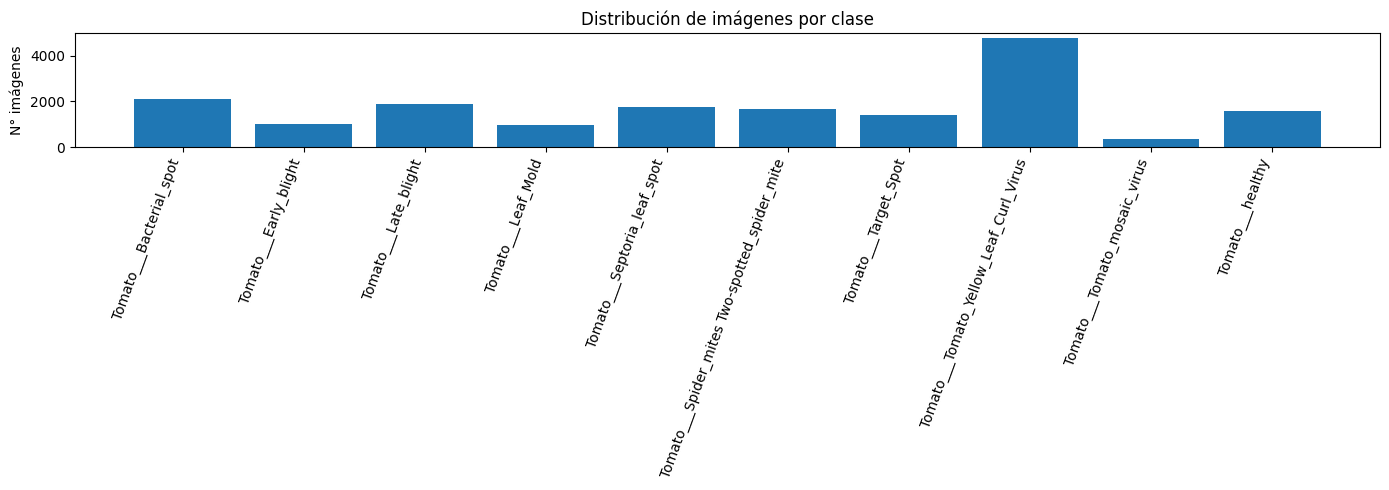


Resumen:
Clases con 0 imágenes: []
Clases con 1 imagen   : []
Clases con >=2 imgs   : ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


In [ ]:
# =========================
# BLOQUE 3: EDA - conteo por clase (robusto)
# =========================
from collections import OrderedDict
import matplotlib.pyplot as plt

IMG_EXTS = ["*.jpg","*.jpeg","*.png","*.JPG","*.JPEG","*.PNG","*.bmp","*.BMP","*.webp","*.WEBP"]

def list_images_in_class(cls_folder):
    cls_path = os.path.join(DATA_DIR, cls_folder)
    imgs = []
    for ext in IMG_EXTS:
        imgs += glob.glob(os.path.join(cls_path, ext))
    return imgs

# Reset explícito
class_counts = OrderedDict()
for cls in class_names_all:
    class_counts[cls] = len(list_images_in_class(cls))

print("Conteo por clase:")
for cls, n in sorted(class_counts.items(), key=lambda x: x[1]):
    print(f"{cls}: {n}")

plt.figure(figsize=(14,5))
plt.bar(range(len(class_counts)), list(class_counts.values()))
plt.xticks(range(len(class_counts)), list(class_counts.keys()), rotation=70, ha="right")
plt.ylabel("N° imágenes")
plt.title("Distribución de imágenes por clase")
plt.tight_layout()
plt.show()

print("\nResumen:")
print("Clases con 0 imágenes:", [c for c,n in class_counts.items() if n == 0])
print("Clases con 1 imagen   :", [c for c,n in class_counts.items() if n == 1])
print("Clases con >=2 imgs   :", [c for c,n in class_counts.items() if n >= 2])



# Bloque 4 — Preparar clases válidas (aquí deben quedar las 10)


### Objetivo general
Este bloque define formalmente **qué clases serán consideradas en el problema de clasificación**, asegurando que el dataset cumpla condiciones mínimas para:

- entrenar un modelo **multiclase** de forma coherente,
- realizar **splits estratificados** (cuando corresponda),
- construir etiquetas consistentes y reproducibles,
- evitar errores metodológicos (por ejemplo, entrenar con clases vacías o insuficientes).

En términos prácticos, este bloque convierte el listado “crudo” de clases del dataset en el conjunto final de clases que el modelo podrá predecir.

---

### Paso 1: Definir un umbral mínimo de imágenes por clase
Se establece un parámetro que exige un número mínimo de ejemplos por clase (por defecto, 2).

**Justificación técnica:**
- Con menos de 2 imágenes en una clase, no es posible garantizar que esa clase pueda aparecer en distintos subconjuntos (train/val/test).
- En particular, los métodos de división **estratificada** requieren al menos 2 instancias por clase para funcionar correctamente.
- Aunque 2 es el mínimo matemático, desde una perspectiva metodológica se recomienda un umbral mayor (por ejemplo 20–50+) para mejorar generalización.

---

### Paso 2: Filtrar las clases que cumplen el umbral
A partir del conteo previo de imágenes por clase, se seleccionan únicamente aquellas clases cuyo número de imágenes es mayor o igual al umbral definido.

**Resultado conceptual:**
- Se elimina ruido y posibles clases “inválidas” (vacías o con muy pocos datos).
- Se garantiza que el conjunto de clases utilizado es consistente con el tipo de problema (multiclase) y con el procedimiento de evaluación.

---

### Paso 3: Validación de viabilidad del problema multiclase
Se verifica que existan al menos **dos clases válidas**.

**Por qué es obligatorio:**
- Si queda solo una clase, el problema ya no es clasificación multiclase (se vuelve trivial).
- En ese caso, cualquier modelo obtendría métricas artificialmente altas (por ejemplo, accuracy = 1.0) simplemente prediciendo siempre la misma clase.
- Por ello, se detiene la ejecución mediante una excepción explícita, forzando a revisar el dataset antes de continuar.

---

### Paso 4: Estabilizar el conjunto de clases y su orden
Una vez validadas las clases, se ordenan alfabéticamente y se asignan como la lista oficial de clases.

**Relevancia crítica:**
- El orden de esta lista define el mapeo **índice ↔ clase**.
- Ese mapeo determina:
  - el tamaño de la capa de salida (*softmax*),
  - la codificación *one-hot* de etiquetas,
  - la interpretación de predicciones,
  - los reportes de desempeño (por ejemplo, matriz de confusión, classification report).

La ordenación garantiza reproducibilidad: el mismo dataset producirá siempre la misma correspondencia.

---

### Paso 5: Definir el número total de clases
Se calcula el número de clases válidas, lo cual determina directamente:

- la dimensionalidad del vector de salida del modelo,
- el número de neuronas de la última capa,
- el número de categorías en métricas multiclase.

---

### Paso 6: Imprimir el resultado para verificación
Finalmente, se imprime:

- el número total de clases consideradas,
- el listado de clases.

**Propósito:** proporcionar evidencia inmediata de que:
- el dataset fue leído correctamente,
- el problema multiclase es viable,
- el modelo tendrá un espacio de salida coherente.

---

### Resultado esperado del bloque
Al ejecutarlo, se obtiene:

1. Un conjunto definitivo de clases válidas.
2. El número total de clases (que coincide con la salida del modelo).
3. Una validación preventiva que evita entrenamientos inválidos o métricas engañosas.

Este bloque cumple un rol metodológico esencial: **garantiza consistencia entre datos, etiquetas y arquitectura del modelo** antes de pasar a la construcción del dataset y al entrenamiento.


In [ ]:
# =========================
# BLOQUE 4: Clases válidas (sin errores)
# =========================
MIN_IMAGES_PER_CLASS = 2

valid_classes = [c for c,n in class_counts.items() if n >= MIN_IMAGES_PER_CLASS]
if len(valid_classes) < 2:
    raise ValueError("No hay suficientes clases para clasificación multiclase. Revisa el dataset.")

# Reset explícito de class_names usados en el modelo
class_names = sorted(valid_classes)
num_classes = len(class_names)

print(" num_classes =", num_classes)
print("class_names =", class_names)


 num_classes = 10
class_names = ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


# BLOQUE 5 — Construir paths + labels (correcto y reproducible)


### Objetivo general
Este bloque transforma la estructura del dataset basada en carpetas en una representación estándar para *Machine Learning*, construyendo:

- **`all_paths`**: una lista con las rutas de todas las imágenes disponibles.
- **`all_labels`**: una lista con la etiqueta numérica asociada a cada imagen.

En términos de aprendizaje supervisado, este bloque crea el conjunto de datos en formato:

- **Entrada (X)**: ruta de la imagen (que luego se cargará como tensor)
- **Salida (y)**: clase (etiqueta) correspondiente

---

### Paso 1: Inicialización de contenedores
Se crean dos listas vacías:

- Una para almacenar las rutas de todas las imágenes.
- Otra para almacenar las etiquetas numéricas de esas imágenes.

**Justificación:**  
Trabajar inicialmente con listas permite construir el dataset de forma incremental, agregando imágenes clase por clase.

---

### Paso 2: Recorrido de clases con índice asociado
Se recorre el listado oficial de clases (`class_names`) usando una enumeración que entrega:

- **`idx`**: índice numérico de la clase (0, 1, 2, …, K−1).
- **`cls`**: nombre textual de la clase (p. ej., `Tomato___Late_blight`).

**Relevancia crítica:**  
El índice `idx` es la representación numérica que el modelo utilizará internamente.  
Por tanto, este bloque define la relación:

> `idx` ↔ `nombre de la clase`

y esa relación se mantiene en todo el pipeline (one-hot encoding, softmax, reportes, etc.).

---

### Paso 3: Obtención de imágenes por clase
Para cada clase, se obtiene la lista de imágenes presentes en su carpeta mediante una función de listado robusta (considerando extensiones comunes).

- El resultado es un conjunto de rutas de archivos para esa clase.

**Propósito:**  
Separar claramente la lógica de acceso al dataset (listado de archivos) de la lógica de construcción de etiquetas.

---

### Paso 4: Construcción paralela de rutas y etiquetas
Se agregan:

- todas las rutas encontradas de esa clase al contenedor global de rutas,
- y, en paralelo, se agregan tantas etiquetas `idx` como imágenes existan en esa clase.

Esto genera un alineamiento uno-a-uno:

- `all_paths[j]` corresponde a la imagen j
- `all_labels[j]` corresponde a la clase de esa misma imagen

**Por qué es importante:**  
Este alineamiento es esencial para entrenar modelos supervisados: el algoritmo aprende la relación entre la entrada y la etiqueta correcta.

---

### Paso 5: Conversión a arreglos NumPy
Una vez terminada la construcción:

- las listas se convierten en arreglos NumPy.

**Ventajas prácticas:**
- facilitan operaciones vectorizadas (por ejemplo, conteos por clase),
- son compatibles con funciones de *scikit-learn* (p. ej., `train_test_split`),
- permiten indexación eficiente.

---

### Paso 6: Verificación del tamaño total del dataset
Se imprime el total de imágenes disponibles.

**Interpretación:**
- Este valor corresponde al tamaño del dataset completo que será dividido en train/val/test.
- Permite detectar problemas como “dataset incompleto” o rutas mal resueltas.

---

### Paso 7: Verificación de distribución por clase (sanity check)
Se imprime un resumen por clase indicando:

- el índice numérico de la clase,
- el nombre textual de la clase,
- el número de imágenes asociadas a ese índice.

**Relevancia metodológica:**
- Permite confirmar que las etiquetas se asignaron correctamente.
- Identifica desbalance de clases (clases con muchas más imágenes que otras).
- Anticipa decisiones posteriores, como el uso de:
  - *class weights*,
  - métricas robustas (Macro F1),
  - o estrategias de aumento de datos.

---

### Resultado esperado del bloque
Al finalizar, se obtiene:

1. Una lista/array de **rutas de imágenes** (`all_paths`).
2. Un array de **etiquetas numéricas** (`all_labels`) alineadas con las rutas.
3. Evidencia cuantitativa del tamaño total y la distribución por clase.

Este bloque es un paso clave porque convierte un dataset “en carpetas” en un formato **directamente utilizable** por técnicas de división estratificada, pipelines de lectura (`tf.data`) y entrenamiento de modelos de Deep Learning.


In [ ]:
# =========================
# BLOQUE 5: Construcción de paths y labels
# =========================
all_paths, all_labels = [], []

for idx, cls in enumerate(class_names):
    imgs = list_images_in_class(cls)
    all_paths.extend(imgs)
    all_labels.extend([idx] * len(imgs))

all_paths = np.array(all_paths)
all_labels = np.array(all_labels)

print("Total imágenes:", len(all_paths))
print("Distribución por clase (índice -> clase -> n):")
for i, cls in enumerate(class_names):
    print(f"{i:2d} -> {cls} -> {(all_labels==i).sum()}")


Total imágenes: 17543
Distribución por clase (índice -> clase -> n):
 0 -> Tomato___Bacterial_spot -> 2126
 1 -> Tomato___Early_blight -> 998
 2 -> Tomato___Late_blight -> 1897
 3 -> Tomato___Leaf_Mold -> 952
 4 -> Tomato___Septoria_leaf_spot -> 1771
 5 -> Tomato___Spider_mites Two-spotted_spider_mite -> 1676
 6 -> Tomato___Target_Spot -> 1404
 7 -> Tomato___Tomato_Yellow_Leaf_Curl_Virus -> 4761
 8 -> Tomato___Tomato_mosaic_virus -> 373
 9 -> Tomato___healthy -> 1585


# BLOQUE 6 —  Split estratificado train/val/test



### Objetivo general
Este bloque realiza la partición del dataset en tres subconjuntos fundamentales para *Machine Learning* y *Deep Learning*:

- **Entrenamiento (train):** se usa para ajustar los parámetros del modelo (pesos).
- **Validación (validation):** se usa para seleccionar hiperparámetros, aplicar *early stopping* y comparar modelos sin “mirar” el test.
- **Prueba (test):** se reserva exclusivamente para la evaluación final y honesta del desempeño (generalización).

Además, la división es **estratificada**, lo que significa que busca conservar aproximadamente la **misma proporción de clases** en cada subconjunto.

---

### Paso 1: Importación del método de partición
Se utiliza una función estándar de *scikit-learn* para dividir datos de manera reproducible, flexible y ampliamente aceptada en entornos académicos y profesionales.

---

### Paso 2: Definición de proporciones de partición
Se definen dos hiperparámetros de partición:

- **Proporción de test (`TEST_SIZE = 0.20`):**  
  Se reserva el 20% del dataset para evaluación final.

- **Proporción de validación dentro del conjunto train+val (`VAL_SIZE_IN_TRAINVAL = 0.15`):**  
  Del conjunto restante (80%), se separa un 15% para validación.

**Interpretación porcentual aproximada final:**
- Test: 20%
- Validación: 0.15 × 80% ≈ 12%
- Entrenamiento: 80% − 12% ≈ 68%

Este esquema es común porque permite:
- suficiente información para entrenar,
- validación estable para decisiones de modelo,
- test suficientemente grande para estimar generalización.

---

### Paso 3: Primera partición — separar Test del resto
Se divide el dataset completo en:

- **Train+Val:** ~80%
- **Test:** ~20%

#### Estratificación
Se aplica estratificación usando las etiquetas del dataset completo, de modo que la distribución de clases en el test sea representativa del conjunto original.

#### Reproducibilidad
Se fija una semilla (`random_state = SEED`) para que la partición sea repetible.

**Justificación metodológica:**  
El conjunto de test debe permanecer “intacto” durante el desarrollo; por ello se separa primero, evitando sesgos por decisiones tomadas luego de observar su desempeño.

---

### Paso 4: Segunda partición — separar Validation desde Train+Val
Se vuelve a dividir el subconjunto Train+Val en:

- **Train:** ~85% de train+val
- **Validation:** ~15% de train+val

#### Estratificación en esta etapa
La estratificación ahora se aplica respecto a `y_trainval` (las etiquetas del subconjunto Train+Val), asegurando que la validación mantenga proporciones de clases comparables a train.

**Importancia práctica:**
- Permite monitorear sobreajuste (train mejora mientras val empeora).
- Permite seleccionar hiperparámetros y arquitecturas sin “contaminar” el test.

---

### Paso 5: Verificaciones de consistencia (sanity checks)
Se imprimen:

1. El tamaño (número de muestras) de Train, Validation y Test.
2. El número de clases únicas presentes en cada split.

**Objetivo de estas verificaciones:**
- Confirmar que el split generó subconjuntos con datos suficientes.
- Verificar que no se perdió alguna clase en un split (lo que puede ocurrir si una clase tiene muy pocos ejemplos).
- Asegurar que el entrenamiento multiclase es viable en todas las etapas.

---

### Interpretación académica clave
- La separación **train/val/test** es un requisito básico para evaluación honesta.
- La **estratificación** es especialmente relevante cuando existe **desbalance de clases**, pues evita que una partición tenga clases subrepresentadas o ausentes.
- Mantener el test aislado preserva la validez de la evaluación final y evita *data leakage* por ajuste indirecto a los datos de prueba.

---

### Resultado esperado del bloque
Al finalizar, el bloque produce:

- Conjuntos de rutas de imágenes y etiquetas para:
  - entrenamiento,
  - validación,
  - prueba.
- Confirmación de tamaños y cobertura de clases en cada split.

Este paso es crítico para cumplir buenas prácticas de *Machine Learning* y para que las métricas reportadas reflejen realmente la capacidad de generalización del modelo.


In [ ]:
# =========================
# BLOQUE 6: Split estratificado train/val/test
# =========================
from sklearn.model_selection import train_test_split

TEST_SIZE = 0.20
VAL_SIZE_IN_TRAINVAL = 0.15

X_trainval, X_test, y_trainval, y_test = train_test_split(
    all_paths, all_labels,
    test_size=TEST_SIZE,
    stratify=all_labels,
    random_state=SEED
)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval,
    test_size=VAL_SIZE_IN_TRAINVAL,
    stratify=y_trainval,
    random_state=SEED
)

print("Train:", len(X_train), "Val:", len(X_val), "Test:", len(X_test))
print("Clases en Train:", len(np.unique(y_train)))
print("Clases en Val  :", len(np.unique(y_val)))
print("Clases en Test :", len(np.unique(y_test)))



Train: 11928 Val: 2106 Test: 3509
Clases en Train: 10
Clases en Val  : 10
Clases en Test : 10


# BLOQUE 7 — Class Weights (para desbalance, mejora Macro F1)


### Objetivo general
Este bloque calcula **pesos por clase** (*class weights*) para corregir el efecto del **desbalance** en el conjunto de entrenamiento. En problemas de clasificación multiclase, cuando algunas clases tienen muchas más imágenes que otras, el modelo tiende a:

- aprender con mayor facilidad las clases mayoritarias,
- minimizar la pérdida priorizando aciertos en clases frecuentes,
- presentar buen *accuracy* pero mal desempeño en clases minoritarias (bajo *recall* o bajo *Macro F1*).

Los *class weights* ajustan la función de pérdida para que los errores en clases raras “cuesten más” y, por tanto, el modelo se vea incentivado a aprenderlas.

---

### Paso 1: Importación de la utilidad para pesos balanceados
Se utiliza una función estándar de *scikit-learn* que implementa una estrategia de pesos “balanceada”, ampliamente utilizada en entornos académicos y prácticos.

**Ventaja:** permite calcular automáticamente pesos proporcionales a la frecuencia de cada clase, evitando estimaciones manuales.

---

### Paso 2: Cálculo de pesos balanceados usando el conjunto de entrenamiento
Se calculan los pesos a partir de:

- el número total de clases,
- las clases representadas como índices (0 a K−1),
- las etiquetas del conjunto de entrenamiento (`y_train`).

#### Principio matemático (intuición)
La estrategia *balanced* asigna pesos inversamente proporcionales a la frecuencia:

- Clases más frecuentes → **peso menor**
- Clases menos frecuentes → **peso mayor**

Una forma común de expresar esta idea es:

\[
w_c \propto \frac{N}{K \cdot n_c}
\]

donde:
- \(N\) es el número total de muestras de entrenamiento,
- \(K\) es el número de clases,
- \(n_c\) es el número de muestras de la clase \(c\).

**Interpretación:** si una clase tiene pocos ejemplos, su peso aumenta, haciendo que los errores en esa clase afecten más el entrenamiento.

---

### Paso 3: Conversión a formato utilizable por Keras/TensorFlow
El resultado inicial del cálculo es una estructura indexada (por ejemplo, un arreglo).

Luego se convierte a un diccionario con el formato:

- clave: índice de clase (0, 1, 2, …)
- valor: peso numérico

**Por qué se hace esto:**  
Keras recibe los *class weights* típicamente como un diccionario para aplicar esos pesos durante el cálculo de la pérdida.

---

### Paso 4: Reporte de los pesos calculados
Se imprime cada peso asociado a:

- el índice de clase,
- el nombre de la clase,
- el valor del peso con precisión controlada.

**Propósito del reporte:**
- Verificar que el cálculo tiene sentido (clases raras deben tener mayor peso).
- Documentar el manejo del desbalance para el informe/presentación.
- Justificar que la evaluación debe incluir métricas más robustas (por ejemplo, *Macro F1*).

---

### Impacto esperado en el desempeño del modelo
Aplicar *class weights* suele producir:

- **Mejora en clases minoritarias** (mayor *recall* y *F1* por clase).
- **Aumento del Macro F1** (promedio uniforme entre clases).
- Posible **reducción leve del accuracy global**, porque el modelo deja de privilegiar solo la clase mayoritaria.

Esto no es una “pérdida”, sino un comportamiento deseable cuando el objetivo es un desempeño equilibrado entre clases.

---

### Resultado esperado del bloque
Al ejecutar este bloque se obtiene:

1. Un conjunto de pesos balanceados por clase basado en el **train** (no en val/test).
2. Un diccionario listo para ser entregado al entrenamiento del modelo.
3. Evidencia cuantitativa de la magnitud del desbalance.

Este paso es consistente con buenas prácticas, ya que evita que el modelo aprenda una solución sesgada hacia las clases más frecuentes y mejora la validez del análisis en un escenario multiclase real.


In [ ]:
# =========================
# BLOQUE 7: Class weights (recomendado por desbalance)
# =========================
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.arange(num_classes),
    y=y_train
)
class_weights = {i: w for i, w in enumerate(class_weights)}

print("Class weights:")
for i, w in class_weights.items():
    print(f"{i:2d} -> {class_names[i]} -> {w:.4f}")


Class weights:
 0 -> Tomato___Bacterial_spot -> 0.8249
 1 -> Tomato___Early_blight -> 1.7593
 2 -> Tomato___Late_blight -> 0.9254
 3 -> Tomato___Leaf_Mold -> 1.8407
 4 -> Tomato___Septoria_leaf_spot -> 0.9907
 5 -> Tomato___Spider_mites Two-spotted_spider_mite -> 1.0463
 6 -> Tomato___Target_Spot -> 1.2490
 7 -> Tomato___Tomato_Yellow_Leaf_Curl_Virus -> 0.3685
 8 -> Tomato___Tomato_mosaic_virus -> 4.7146
 9 -> Tomato___healthy -> 1.1065


# BLOQUE 8 — tf.data.Dataset



### Objetivo general
Este bloque implementa un *pipeline* de entrada de datos usando `tf.data`, que es el mecanismo recomendado en TensorFlow para:

- leer imágenes desde disco de forma eficiente,
- aplicar preprocesamiento de manera consistente,
- generar lotes (*batches*) para entrenamiento,
- optimizar rendimiento con paralelización y *prefetch*.

En resumen, este bloque transforma rutas de archivos y etiquetas (datos “crudos”) en tensores listos para ser consumidos por el modelo.

---

### Paso 1: Definición de hiperparámetros del pipeline
Se establecen parámetros clave que determinan el comportamiento del flujo de datos:

- **Tamaño de imagen (`IMG_SIZE`)**: define la resolución a la que se redimensionarán todas las imágenes (por ejemplo 224×224).  
  **Motivo:** los modelos CNN/Transfer Learning requieren una entrada de tamaño fijo.

- **Tamaño de lote (`BATCH_SIZE`)**: cantidad de imágenes procesadas en cada paso de entrenamiento.  
  **Impacto:** valores mayores aprovechan mejor GPU pero consumen más memoria; valores menores pueden estabilizar entrenamiento si hay limitaciones de RAM/VRAM.

- **`AUTOTUNE`**: permite que TensorFlow determine automáticamente el nivel óptimo de paralelización y prelectura según el hardware disponible.

---

### Paso 2: Función de carga y preprocesamiento por muestra
Se define una función que toma como entrada:

- una **ruta de archivo** (path),
- una **etiqueta numérica** (label),

y devuelve:

- la **imagen como tensor** (preprocesada),
- la **etiqueta en formato one-hot**.

Los subpasos principales son:

1. **Lectura del archivo desde disco**  
   Se carga el contenido binario del archivo de imagen.

2. **Decodificación a tensor RGB**  
   Se convierte el archivo a un tensor con 3 canales (RGB).  
   Se desactiva la expansión de animaciones para asegurar que imágenes tipo GIF no generen secuencias.

3. **Redimensionamiento**  
   Se ajusta la imagen al tamaño definido en `IMG_SIZE`, logrando homogeneidad en la entrada del modelo.

4. **Fijación explícita de forma (shape)**  
   Se establece la forma exacta del tensor para evitar ambigüedades en el grafo computacional (esto mejora compatibilidad y evita errores posteriores).

5. **Codificación one-hot de la etiqueta**  
   La etiqueta numérica se transforma a un vector de longitud `num_classes` donde:
   - el índice correspondiente a la clase vale 1,
   - los demás valen 0.

   **Justificación:** es el formato estándar cuando se usa `softmax` como salida y `categorical_crossentropy` como función de pérdida.

---

### Paso 3: Función para construir un `Dataset` completo (train/val/test)
Se define una función general que, a partir de:

- un conjunto de rutas (`X`)
- un conjunto de etiquetas (`y`)
- un indicador de modo (`training`)

construye un pipeline completo usando operaciones típicas de `tf.data`:

1. **Crear dataset desde tensores**  
   Se construye un `Dataset` que produce pares (path, label) en el mismo orden.

2. **Mezcla (*shuffle*) solo para entrenamiento**  
   Si `training=True`, se aplica barajado para romper correlaciones del orden del disco y mejorar generalización.

   - El tamaño del buffer controla cuántos elementos se mezclan en memoria.
   - Se define una semilla para reproducibilidad.
   - Se permite que el barajado cambie entre epochs (comportamiento deseable en entrenamiento).

3. **Aplicar `map` con paralelización**  
   Se aplica la función de carga/preprocesamiento a cada elemento.
   Se habilita procesamiento paralelo para acelerar lectura y decodificación.

4. **Agrupar en lotes (`batch`)**  
   Se agrupan muestras en batches del tamaño definido, que es el formato que consume el entrenamiento del modelo.

5. **Prelectura (`prefetch`)**  
   Se habilita `prefetch` para solapar:
   - preparación de datos en CPU
   - entrenamiento en GPU

   **Resultado:** mejora considerable del rendimiento y evita que la GPU “espere” por datos.

---

### Paso 4: Creación de los tres conjuntos del experimento
Se construyen tres datasets independientes usando la misma función:

- **`train_ds`**: incluye shuffle y se usa para ajustar pesos.
- **`val_ds`**: sin shuffle; se usa para monitorear desempeño durante entrenamiento.
- **`test_ds`**: sin shuffle; se usa para evaluación final.

**Importancia metodológica:**  
Mantener validación y test sin shuffle preserva consistencia en evaluación y facilita depuración.

---

### Paso 5: Confirmación de preparación del pipeline
Se imprime un mensaje final confirmando que los datasets están listos para:

- entrenamiento,
- validación,
- prueba.

---

### Impacto esperado del bloque (por qué es buena práctica)
Usar `tf.data` aporta:

- eficiencia (paralelización + prefetch),
- reproducibilidad (semillas),
- consistencia del preprocesamiento,
- escalabilidad para datasets grandes,
- integración óptima con TensorFlow y GPU.

Este bloque es esencial para un notebook profesional, ya que implementa el estándar recomendado para pipelines de visión por computador en TensorFlow.


In [ ]:
# =========================
# BLOQUE 8: tf.data.Dataset
# =========================
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img.set_shape((*IMG_SIZE, 3))
    label = tf.one_hot(label, depth=num_classes)
    return img, label

def make_dataset(X, y, training=False):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if training:
        ds = ds.shuffle(2000, seed=SEED, reshuffle_each_iteration=True)
    ds = ds.map(load_image, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = make_dataset(X_train, y_train, training=True)
val_ds   = make_dataset(X_val, y_val, training=False)
test_ds  = make_dataset(X_test, y_test, training=False)

print(" Datasets listos.")



 Datasets listos.


# BLOQUE 9 — Data Augmentation



### Objetivo general
Este bloque define un módulo de **aumento de datos** (*data augmentation*) utilizando capas nativas de Keras. El propósito es **incrementar la variabilidad efectiva** del conjunto de entrenamiento aplicando transformaciones aleatorias a las imágenes, sin modificar sus etiquetas.

En visión por computador, el *augmentation* actúa como una forma de **regularización**, ayudando a reducir el sobreajuste y mejorando la capacidad de generalización del modelo ante condiciones reales (cambios de orientación, iluminación, escala, etc.).

---

### Paso 1: Construcción de un pipeline de transformaciones
Se crea un modelo secuencial (un contenedor) que agrupa varias transformaciones aleatorias en un único bloque reutilizable. Este bloque puede insertarse directamente en la arquitectura del modelo, asegurando que:

- las transformaciones se ejecuten **dentro del grafo de TensorFlow**,
- sean **rápidas** (aprovechando optimizaciones),
- mantengan consistencia con el entrenamiento,
- faciliten reproducibilidad y despliegue.

---

### Paso 2: Transformación 1 — Reflexión horizontal aleatoria (*Random Flip*)
Se aplica una inversión horizontal con cierta probabilidad.

**Justificación:**  
En imágenes de hojas, la orientación izquierda/derecha generalmente no cambia la clase (la enfermedad sigue siendo la misma), por lo que esta transformación ayuda a que el modelo aprenda patrones relevantes independientes de la orientación.

---

### Paso 3: Transformación 2 — Rotación aleatoria (*Random Rotation*)
Se permite una rotación pequeña (por ejemplo ±5% de una vuelta completa).

**Justificación:**  
En escenarios reales, las hojas se capturan con variaciones de ángulo por:
- inclinación de cámara,
- postura de la hoja,
- perspectiva del operador.

La rotación controlada mejora robustez sin distorsionar en exceso la morfología de la lesión.

---

### Paso 4: Transformación 3 — Zoom aleatorio (*Random Zoom*)
Se aplica un acercamiento o alejamiento leve.

**Justificación:**  
Las lesiones pueden ocupar distintas proporciones de la imagen dependiendo de:
- distancia de captura,
- recorte implícito,
- tamaño de la hoja.

El zoom ayuda a que el modelo aprenda patrones de enfermedad tanto en escalas cercanas como moderadas.

---

### Paso 5: Transformación 4 — Contraste aleatorio (*Random Contrast*)
Se altera el contraste de forma controlada.

**Justificación:**  
La variabilidad de iluminación en campo es alta (sombras, luz directa, nublado, diferentes cámaras). Ajustar contraste durante entrenamiento simula esta variabilidad y reduce la dependencia del modelo a condiciones de luz específicas.

---

### Paso 6: Nombrado del bloque de augmentación
Se asigna un nombre al módulo para:

- mejorar trazabilidad y legibilidad en el resumen del modelo (`model.summary()`),
- facilitar depuración,
- permitir identificar claramente el componente en la arquitectura.

---

### Cuándo se aplica y por qué es buena práctica
- El *augmentation* se aplica típicamente **solo durante entrenamiento** (de manera estocástica).
- En validación y test se evalúa con imágenes sin augmentación, para medir desempeño real.
- Reduce sobreajuste al exponer al modelo a múltiples variantes de la misma imagen.

---

### Impacto esperado en el desempeño
- **Mejor generalización** (mejor desempeño en datos no vistos).
- Mayor robustez ante variaciones de captura.
- Puede aumentar ligeramente el tiempo de entrenamiento, pero suele mejorar métricas relevantes (por ejemplo, *Macro F1* en clases difíciles).

---

### Resultado esperado del bloque
Al finalizar, se dispone de un componente reutilizable de *data augmentation* que puede integrarse en el modelo EfficientNet/CNN para fortalecer el aprendizaje y disminuir el riesgo de sobreajuste en la tarea de clasificación de enfermedades en hojas de tomate.


In [ ]:
# =========================
# BLOQUE 9: Data augmentation
# =========================
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.10),
    tf.keras.layers.RandomContrast(0.10),
], name="augmentation")


# BLOQUE 10 — EfficientNetB0 con *Transfer Learning* para clasificación multiclase


### Objetivo general
Este bloque construye y configura un modelo de clasificación de imágenes basado en **EfficientNetB0** utilizando **transfer learning**. La idea central es reutilizar un modelo previamente entrenado en un gran corpus de imágenes (ImageNet) como **extractor de características**, y añadir una “cabeza” de clasificación adaptada a las clases del problema (enfermedades del tomate).

Este enfoque es particularmente adecuado cuando:
- el dataset, aunque grande, puede presentar variabilidad (iluminación, ángulos, fondos),
- se busca un modelo robusto con entrenamiento más eficiente,
- se desea aprovechar representaciones visuales generales aprendidas previamente.

---

### Paso 1: Importación del modelo preentrenado y su preprocesamiento específico
Se importan dos elementos clave:

- **Arquitectura EfficientNetB0**: una red convolucional optimizada en términos de precisión/eficiencia.
- **Función de preprocesamiento asociada**: normaliza/transforma los píxeles de entrada exactamente como espera EfficientNet.

**Justificación:**  
Los modelos preentrenados requieren que la entrada siga el mismo esquema de normalización usado durante el preentrenamiento; de lo contrario, se degrada el desempeño.

---

### Paso 2: Definición de la capa de entrada del modelo
Se define un tensor de entrada con forma:
- alto = `IMG_SIZE[0]`
- ancho = `IMG_SIZE[1]`
- canales = 3 (RGB)

**Relevancia:**  
Establece el contrato de entrada del modelo y permite que todas las transformaciones posteriores trabajen con dimensiones consistentes.

---

### Paso 3: Aplicación de *data augmentation* (regularización)
Las imágenes de entrada pasan por el bloque de aumento de datos definido previamente.

**Propósito académico:**
- aumentar diversidad efectiva del entrenamiento,
- disminuir sobreajuste,
- mejorar robustez ante variaciones reales (orientación, escala, contraste).

---

### Paso 4: Preprocesamiento específico de EfficientNet
Luego del augmentation, se aplica el preprocesamiento oficial del modelo.

**Qué se logra aquí:**
- adaptar rango y distribución de píxeles al estándar del backbone,
- alinear la entrada con el preentrenamiento en ImageNet,
- facilitar la transferencia de conocimiento desde el modelo base.

---

### Paso 5: Carga de EfficientNetB0 como backbone (sin la “cabeza” original)
Se instancia EfficientNetB0 con:

- **`include_top=False`**: elimina la capa final original de ImageNet (1000 clases), dejando solo el extractor de características.
- **`weights="imagenet"`**: carga pesos preentrenados.
- **`input_shape`** consistente con el tamaño definido.

**Interpretación conceptual:**  
EfficientNetB0 actúa como un **codificador visual** que transforma la imagen en un conjunto de mapas de características de alto nivel.

---

### Paso 6: Congelamiento del backbone (feature extraction)
Se deshabilita el entrenamiento del modelo base.

**Justificación metodológica:**
- al inicio se busca entrenar solo la cabeza final (clasificador),
- evita destruir representaciones útiles preentrenadas (*catastrophic forgetting*),
- acelera entrenamiento y reduce riesgo de sobreajuste.

Este enfoque corresponde a la fase de **feature extraction** del transfer learning.

---

### Paso 7: Propagación hacia el backbone en modo inferencia
El backbone se ejecuta con `training=False`.

**Motivo técnico:**
- asegura comportamiento determinista de capas internas con comportamiento distinto en entrenamiento/inferencia (p. ej., BatchNorm),
- estabiliza el aprendizaje cuando el backbone está congelado.

---

### Paso 8: Reducción espacial con *Global Average Pooling*
Se aplica *Global Average Pooling* para convertir los mapas de características 2D en un vector 1D.

**Ventajas:**
- reduce cantidad de parámetros frente a una capa densa grande,
- disminuye sobreajuste,
- mantiene información global relevante,
- es una práctica estándar en arquitecturas modernas de visión.

---

### Paso 9: Regularización con *Dropout*
Se aplica Dropout (por ejemplo 0.4), que apaga aleatoriamente una fracción de activaciones durante entrenamiento.

**Propósito:**
- reducir sobreajuste,
- mejorar generalización,
- forzar al modelo a no depender de un subconjunto reducido de características.

---

### Paso 10: Capa final de clasificación (*softmax*)
Se añade una capa densa con:

- número de neuronas = `num_classes`,
- activación **softmax** para producir una distribución de probabilidad sobre clases.

**Interpretación:**
- cada salida representa \( P(\text{clase} \mid \text{imagen}) \),
- la clase predicha corresponde al índice con mayor probabilidad.

---

### Paso 11: Ensamblaje del modelo completo
Se define el modelo final conectando explícitamente:

- entrada → augmentation → preprocess → backbone → pooling → dropout → salida

Se asigna un nombre identificable al modelo, útil para trazabilidad en reportes y debugging.

---

### Paso 12: Compilación del modelo (definición del problema de optimización)
Se configura el entrenamiento especificando:

- **Optimizador Adam** con tasa de aprendizaje inicial (por ejemplo 1e-3).  
  *Adam es ampliamente usado por su estabilidad y convergencia eficiente en redes profundas.*

- **Función de pérdida `categorical_crossentropy`**: apropiada para clasificación multiclase con etiquetas one-hot.

- **Métrica `accuracy`**: mide proporción de aciertos globales.

**Nota académica importante:**  
En datasets desbalanceados, `accuracy` puede ser engañosa; por eso suele complementarse con métricas como **Macro F1**, *per-class recall*, y matriz de confusión.

---

### Paso 13: Resumen de arquitectura
Se imprime un resumen estructural del modelo, que permite verificar:

- tamaño del input,
- capas utilizadas,
- número de parámetros entrenables vs congelados,
- consistencia del flujo de datos.

Este resumen es evidencia directa para documentación técnica.

---

### Resultado esperado del bloque
Al finalizar:

1. Se obtiene un modelo de clasificación multiclase basado en EfficientNetB0.
2. El backbone está congelado (fase de extracción de características).
3. El modelo queda listo para entrenamiento con un pipeline consistente (augment + preprocess).
4. Se dispone de una arquitectura eficiente y defendible en un entorno académico/profesional para clasificación de enfermedades foliares.


In [ ]:
# =========================
# BLOQUE 10: EfficientNetB0 - Transfer Learning
# =========================
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

inputs = tf.keras.Input(shape=(*IMG_SIZE, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)

base = EfficientNetB0(include_top=False, weights="imagenet", input_shape=(*IMG_SIZE, 3))
base.trainable = False

x = base(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.4)(x)
outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs, name="EffNetB0_TL")

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "EffNetB0_TL"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,062,381 (15.50 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

# BLOQUE 11 — Entrenamiento (con callbacks + class weights)


### Objetivo general
Este bloque ejecuta el **proceso de entrenamiento supervisado** del modelo de Deep Learning, incorporando mecanismos de control automático (*callbacks*) y corrección del desbalance de clases mediante **pesos por clase** (*class weights*). El objetivo es:

- optimizar los parámetros del modelo,
- evitar sobreajuste,
- mejorar la estabilidad del entrenamiento,
- obtener un modelo con mejor capacidad de generalización.

---

### Paso 1: Definición de *callbacks* (control dinámico del entrenamiento)

Los *callbacks* son funciones que se ejecutan automáticamente durante el entrenamiento para **monitorizar y modificar el comportamiento del proceso** sin intervención manual.

#### 1. *Early Stopping*
Se configura un mecanismo de **detención temprana** que observa la pérdida en el conjunto de validación (*validation loss*).

- Si la pérdida de validación no mejora durante un número determinado de épocas consecutivas (*patience*),
  el entrenamiento se detiene.
- Se restauran automáticamente los **mejores pesos** observados (aquellos con menor pérdida de validación).

**Justificación académica:**
- Previene el **sobreajuste**, que ocurre cuando el modelo sigue mejorando en entrenamiento pero empeora en validación.
- Reduce tiempo de cómputo innecesario.
- Garantiza que el modelo final corresponde al mejor punto de generalización observado.

---

#### 2. *Reduce Learning Rate on Plateau*
Se define un mecanismo de **reducción adaptativa de la tasa de aprendizaje** cuando la pérdida de validación se estanca.

- Si la métrica monitoreada no mejora tras un número de épocas consecutivas:
  - la tasa de aprendizaje se reduce multiplicándola por un factor (< 1),
  - se establece un límite inferior para evitar valores excesivamente pequeños.

**Interpretación conceptual:**
- Al inicio del entrenamiento, tasas de aprendizaje más altas permiten avances rápidos.
- Cuando el modelo se acerca a un mínimo, reducir la tasa de aprendizaje permite ajustes más finos y estables.

**Ventaja práctica:**
- Mejora la convergencia.
- Reduce oscilaciones alrededor del mínimo.
- Complementa eficazmente al *Early Stopping*.

---

### Paso 2: Ejecución del entrenamiento supervisado

Se inicia el entrenamiento propiamente tal, utilizando:

- **Dataset de entrenamiento (`train_ds`)**: provee imágenes y etiquetas para ajustar los pesos del modelo.
- **Dataset de validación (`val_ds`)**: se usa exclusivamente para monitorear desempeño y tomar decisiones automáticas (callbacks).
- **Número máximo de épocas**: define un límite superior; el entrenamiento puede terminar antes si se activa *Early Stopping*.

---

### Paso 3: Uso de *class weights* durante el entrenamiento
Se incorporan los **pesos por clase** calculados previamente, de modo que:

- los errores cometidos en clases minoritarias penalicen más la función de pérdida,
- el modelo no se sesgue hacia las clases con mayor cantidad de ejemplos.

**Impacto esperado:**
- mejora del *recall* y *F1-score* en clases poco representadas,
- métricas más equilibradas entre clases,
- entrenamiento más alineado con objetivos multiclase reales.

---

### Paso 4: Almacenamiento del historial de entrenamiento
El proceso de entrenamiento devuelve un objeto que contiene la evolución temporal de métricas como:

- pérdida y precisión en entrenamiento,
- pérdida y precisión en validación,
- cambios en la tasa de aprendizaje.

**Utilidad académica y práctica:**
- permite graficar curvas de aprendizaje,
- facilita el análisis de convergencia,
- sirve como evidencia para justificar decisiones (por ejemplo, uso de *early stopping*).

---

### Interpretación académica del bloque
Este bloque implementa **buenas prácticas estándar en Deep Learning**, combinando:

- regularización implícita (early stopping),
- optimización adaptativa (reducción de learning rate),
- corrección de sesgo por desbalance de datos,
- separación clara entre entrenamiento y validación.

Todo ello contribuye a entrenar un modelo **más estable, robusto y generalizable**, adecuado para ser evaluado posteriormente en un conjunto de prueba independiente.

---

### Resultado esperado del bloque
Al finalizar este bloque:

1. El modelo queda entrenado hasta su mejor punto de desempeño en validación.
2. Se evitan entrenamientos excesivos e inestables.
3. Se obtiene un historial completo del proceso de aprendizaje.
4. El modelo queda listo para una **evaluación final objetiva** sobre el conjunto de test.


In [ ]:
# =========================
# BLOQUE 11: Entrenamiento
# =========================
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6),
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=callbacks,
    class_weight=class_weights
)


Epoch 1/15
373/373 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.5427 - loss: 1.5309 - val_accuracy: 0.8447 - val_loss: 0.6131 - learning_rate: 0.0010
Epoch 2/15
373/373 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.8201 - loss: 0.6967 - val_accuracy: 0.8675 - val_loss: 0.4596 - learning_rate: 0.0010
Epoch 3/15
373/373 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.8528 - loss: 0.5552 - val_accuracy: 0.8889 - val_loss: 0.3865 - learning_rate: 0.0010
Epoch 4/15
373/373 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.8780 - loss: 0.4705 - val_accuracy: 0.9098 - val_loss: 0.3306 - learning_rate: 0.0010
Epoch 5/15
373/373 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.8808 - loss: 0.4283 - val_accuracy: 0.9122 - val_loss: 0.3027 - learning_rate: 0.0010
Epoch 6/15
373/373 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.8868 - loss: 0.4072 - val_accuracy: 0.9179 - val_loss: 0.2740 - learning_rate: 0.0010
Epoch 7/15
373/373 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.8907 - lo

# BLOQUE 12 — Evaluación del modelo en el conjunto de prueba


### Objetivo general
Este bloque realiza la **evaluación final** del modelo sobre el conjunto de prueba (*test set*), utilizando:

- métricas globales provistas por el framework (pérdida y exactitud),
- métricas detalladas por clase (*precision*, *recall*, *F1*),
- una métrica agregada robusta para multiclase desbalanceado (**Macro F1**),
- y la **matriz de confusión** para analizar patrones de error.

El enfoque es “robusto” porque fuerza una evaluación consistente incluso si alguna clase tuviera baja representación en test, evitando errores frecuentes en reportes.

---

### Paso 1: Importación de métricas de evaluación
Se importan herramientas de *scikit-learn* ampliamente usadas en evaluación de clasificación:

- **Reporte de clasificación**: resume *precision*, *recall*, *F1-score* y soporte por clase.
- **Matriz de confusión**: muestra el conteo de aciertos y confusiones entre clases.
- **F1-score**: permite calcular promedios agregados (en particular Macro F1).

**Relevancia:**  
Estas métricas complementan a *accuracy* y son esenciales cuando hay desbalance entre clases, ya que *accuracy* por sí sola puede ser engañosa.

---

### Paso 2: Definición de una función de evaluación reutilizable
Se define una función que encapsula toda la lógica de evaluación. Esto cumple buenas prácticas porque:

- hace el proceso reproducible y modular,
- permite evaluar distintos modelos con la misma metodología,
- evita duplicar código.

---

### Paso 3: Determinación explícita del número de clases y etiquetas válidas
Dentro de la función se obtiene:

- el número total de clases a partir del listado de nombres de clases,
- una lista explícita de etiquetas numéricas válidas (0 a K−1).

**Por qué es importante (robustez):**
- garantiza que el reporte y la matriz se construyan con un conjunto fijo de clases,
- evita discrepancias entre:
  - clases presentes en el dataset,
  - clases presentes en predicciones,
  - clases esperadas por el reporte,
- previene errores típicos del tipo “número de clases no coincide con target_names”.

---

### Paso 4: Recolección de etiquetas reales (*ground truth*) y predicciones
Se inicializan dos contenedores:

- **`y_true`**: etiquetas reales del conjunto test.
- **`y_pred`**: etiquetas predichas por el modelo.

Luego se recorre el dataset por lotes (*batches*):

1. El modelo genera una distribución de probabilidades por clase para cada imagen del batch.
2. Las etiquetas reales vienen en formato *one-hot*, por lo que se convierten a índices de clase tomando la posición del valor máximo.
3. Las predicciones del modelo también se convierten a índices tomando la clase con mayor probabilidad (*argmax*).
4. Se agregan las etiquetas reales y predichas a las listas globales.

**Resultado conceptual:** se obtiene un vector completo de etiquetas reales y predichas para todo el conjunto de prueba.

---

### Paso 5: Cálculo de Macro F1 (métrica prioritaria en multiclase desbalanceado)
Se calcula el **Macro F1**, que corresponde al promedio del F1-score calculado **por clase**, otorgando el mismo peso a cada clase, independiente de su frecuencia.

**Interpretación académica:**
- Si el modelo se desempeña mal en clases minoritarias, el Macro F1 disminuye incluso si el *accuracy* es alto.
- Por ello, Macro F1 es una métrica más representativa cuando el objetivo es desempeño equilibrado entre clases.

**Manejo de casos extremos:**
- Se define qué hacer si alguna clase no tiene predicciones o no aparece en el conjunto evaluado, evitando divisiones por cero y manteniendo la evaluación estable.

---

### Paso 6: Generación del reporte de clasificación por clase
Se imprime un reporte que para cada clase muestra:

- **Precisión (precision):** proporción de predicciones de esa clase que fueron correctas.
- **Exhaustividad (recall):** proporción de instancias reales de esa clase que el modelo logró detectar.
- **F1-score:** media armónica entre precision y recall (balance entre ambos).
- **Soporte (support):** número de ejemplos reales de esa clase en test.

**Valor analítico:**
- Permite detectar clases donde el modelo confunde enfermedades específicas.
- Permite identificar si el modelo es conservador (alto precision, bajo recall) o agresivo (alto recall, bajo precision).

---

### Paso 7: Construcción de la matriz de confusión
Se construye la matriz de confusión forzando el mismo conjunto de clases en filas y columnas.

**Interpretación:**
- La diagonal representa aciertos.
- Valores fuera de la diagonal muestran confusiones sistemáticas (por ejemplo, “Early blight” confundida con “Late blight”).

Esta matriz es clave para el análisis crítico y para proponer mejoras (más datos, mejor augmentación, ajuste fino, etc.).

---

### Paso 8: Evaluación global con TensorFlow (pérdida y accuracy)
Antes o después de la evaluación detallada, se obtiene:

- **Test loss:** valor de la función de pérdida en test (medida del error promedio según el criterio de entrenamiento).
- **Test accuracy:** proporción global de predicciones correctas.

**Nota metodológica:**
- Estas métricas provienen del framework y son útiles como resumen.
- Sin embargo, en desbalance, deben interpretarse junto con Macro F1 y métricas por clase.

---

### Paso 9: Ejecución de la función y obtención del resultado
Finalmente, se llama a la función de evaluación con:

- el modelo entrenado,
- el dataset de prueba,
- el listado de nombres de clases.

La función retorna la matriz de confusión, que queda disponible para el siguiente bloque de visualización.

---

### Resultado esperado del bloque
Al finalizar, se obtiene:

1. **Test loss** y **test accuracy** (visión global del desempeño).
2. **Macro F1** (métrica robusta para comparar modelos en multiclase con desbalance).
3. **Reporte de clasificación** con métricas por clase.
4. **Matriz de confusión** para análisis detallado de errores.

Este conjunto de salidas permite una evaluación completa, defendible y adecuada para un contexto académico o profesional.


In [ ]:
# =========================
# BLOQUE 12: Evaluación robusta
# =========================
from sklearn.metrics import classification_report, confusion_matrix, f1_score

def evaluate_model_fixed(model, ds, class_names):
    num_classes = len(class_names)
    labels_all = list(range(num_classes))

    y_true, y_pred = [], []

    for x_batch, y_batch in ds:
        probs = model.predict(x_batch, verbose=0)
        y_true.extend(np.argmax(y_batch.numpy(), axis=1))
        y_pred.extend(np.argmax(probs, axis=1))

    macro_f1 = f1_score(y_true, y_pred, average="macro", labels=labels_all, zero_division=0)
    print("Macro F1:", macro_f1)

    print("\nReporte de clasificación:")
    print(classification_report(
        y_true, y_pred,
        labels=labels_all,
        target_names=class_names,
        zero_division=0
    ))

    cm = confusion_matrix(y_true, y_pred, labels=labels_all)
    return cm

test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

cm = evaluate_model_fixed(model, test_ds, class_names)


Test loss: 0.2398664355278015
Test accuracy: 0.9244799017906189
Macro F1: 0.9103535555182836

Reporte de clasificación:
                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.96      0.94      0.95       425
                        Tomato___Early_blight       0.92      0.78      0.84       200
                         Tomato___Late_blight       0.94      0.94      0.94       380
                           Tomato___Leaf_Mold       0.91      0.90      0.90       190
                  Tomato___Septoria_leaf_spot       0.90      0.93      0.92       354
Tomato___Spider_mites Two-spotted_spider_mite       0.90      0.87      0.88       335
                         Tomato___Target_Spot       0.75      0.92      0.83       281
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       1.00      0.95      0.97       952
                 Tomato___Tomato_mosaic_virus       0.94      0.91      0.93        75
         

# BLOQUE 13 — Matriz de confusión


### Objetivo general
Este bloque construye una **visualización gráfica de la matriz de confusión** obtenida en la evaluación sobre el conjunto de prueba (*test set*). La matriz de confusión es una herramienta fundamental en clasificación multiclase, ya que permite:

- cuantificar **aciertos y errores por clase**,
- identificar **qué clases se confunden entre sí**,
- complementar métricas agregadas como *accuracy* o *Macro F1* con evidencia interpretativa.

---

### Paso 1: Importación de la librería de visualización
Se utiliza una librería estándar para generar gráficos en notebooks, ampliamente empleada en análisis científico y reportes académicos.

**Propósito:** habilitar la representación visual de la matriz como imagen.

---

### Paso 2: Creación de una figura con tamaño adecuado
Se define un lienzo (*figure*) con dimensiones amplias (por ejemplo 10×10) para que:

- los ejes y etiquetas de clase sean legibles,
- el gráfico no quede comprimido (especialmente cuando hay muchas clases),
- sea apto para capturas en informes o presentaciones.

---

### Paso 3: Representación de la matriz como mapa de calor
La matriz de confusión (variable `cm`) se visualiza como una imagen bidimensional donde:

- cada celda representa un conteo (frecuencia de casos),
- la intensidad del color aumenta con el valor de la celda.

**Interpretación estructural:**
- **Filas (eje Y):** clases reales (*ground truth*).
- **Columnas (eje X):** clases predichas por el modelo.

---

### Paso 4: Incorporación de título descriptivo
Se agrega un título que especifica que la matriz corresponde al conjunto **Test**.

**Relevancia metodológica:**  
Permite diferenciar claramente esta evaluación final de posibles matrices usadas en entrenamiento o validación.

---

### Paso 5: Etiquetado de ejes con nombres de clases
Se asignan etiquetas en ambos ejes utilizando la lista de clases del problema:

- En el eje X se rotan las etiquetas 90° para mejorar legibilidad.
- En el eje Y se mantienen horizontales.

**Importancia:**  
Sin estas etiquetas, la matriz solo mostraría índices numéricos, perdiendo interpretabilidad.

---

### Paso 6: Barra de color (*colorbar*)
Se agrega una escala visual que indica cómo se traduce la intensidad del color en valores numéricos.

**Utilidad:**  
Facilita comparar magnitudes entre celdas, especialmente cuando existen valores muy altos en la diagonal y valores pequeños fuera de ella.

---

### Paso 7: Ajuste automático del diseño
Se aplica un ajuste de márgenes para evitar que:

- las etiquetas queden cortadas,
- el título o ejes se superpongan,
- el gráfico pierda legibilidad.

Esto es especialmente relevante con nombres largos de clases.

---

### Paso 8: Renderizado del gráfico
Finalmente, se muestra la figura en el notebook.

---

## Cómo interpretar la matriz de confusión (lectura académica)
- **Diagonal principal:** corresponde a aciertos por clase (idealmente valores altos).
- **Celdas fuera de la diagonal:** corresponden a errores (confusiones).

### Ejemplos de análisis:
- Si una clase aparece con valores altos en una columna distinta a la suya, significa que el modelo tiende a **confundir sistemáticamente** esa clase con otra.
- Confusiones frecuentes pueden indicar:
  - similitud visual entre enfermedades,
  - insuficiencia de datos en una clase,
  - necesidad de mayor *augmentation*,
  - necesidad de ajuste fino (*fine-tuning*) del backbone,
  - o necesidad de imágenes más representativas (calidad/variabilidad).

---

### Resultado esperado del bloque
Al finalizar, se obtiene una representación visual clara de las confusiones del modelo, que sirve como base para:

- análisis crítico de desempeño por clase,
- discusión metodológica en el informe,
- propuestas de mejora y experimentación posterior.


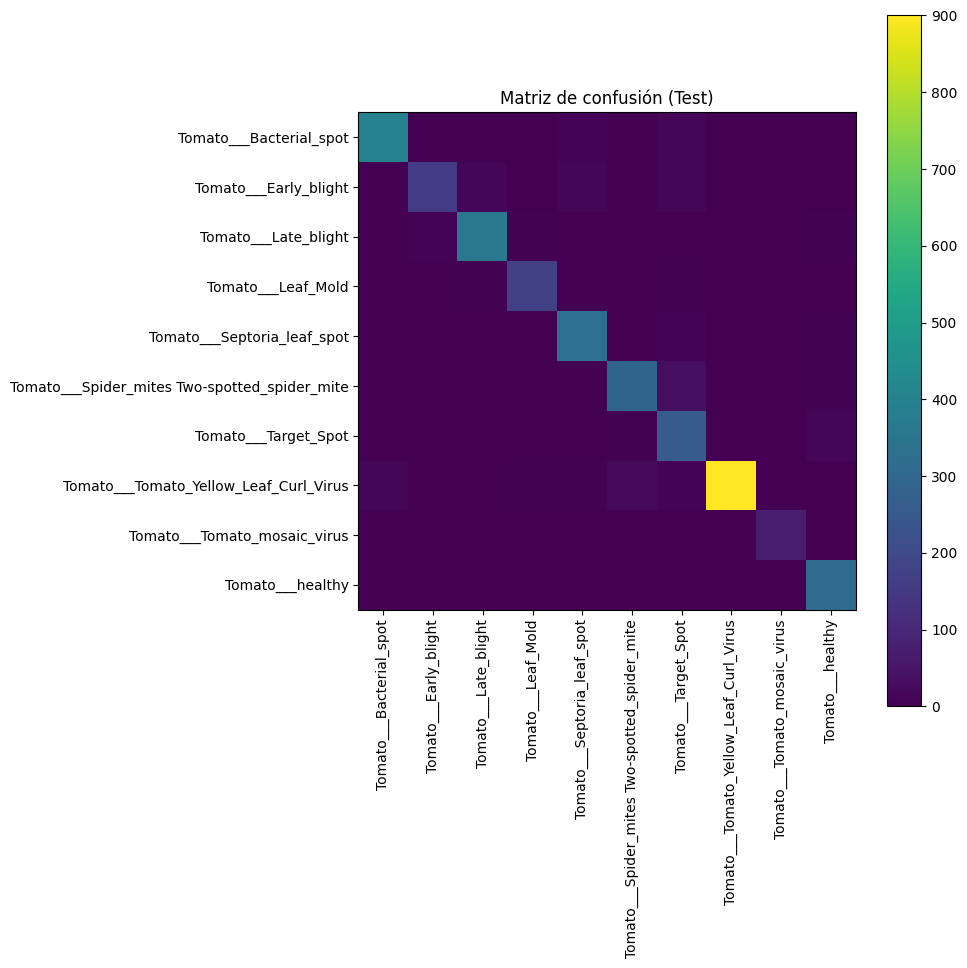

In [ ]:
# =========================
# BLOQUE 13: Matriz de confusión
# =========================
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.imshow(cm)
plt.title("Matriz de confusión (Test)")
plt.xticks(range(num_classes), class_names, rotation=90)
plt.yticks(range(num_classes), class_names)
plt.colorbar()
plt.tight_layout()
plt.show()


# Bloque 14 — Carga de una imagen externa e inferencia con el modelo entrenado (Google Colab)


### Objetivo general
Este bloque implementa un flujo completo de **inferencia** (*inference*) en Google Colab: permite que el usuario **suba una imagen desde su computador**, la somete al **mismo preprocesamiento** utilizado en el entrenamiento y finalmente utiliza el modelo entrenado para:

- predecir la clase más probable (enfermedad/estado),
- reportar la **confianza** de la predicción,
- mostrar las **Top-K clases** con mayor probabilidad.

Este bloque es esencial para demostrar el uso práctico del sistema como clasificador en un escenario real.

---

### Paso 1: Importación de módulos necesarios para inferencia en Colab
Se importan componentes para:

- **subir archivos** desde el computador del usuario (funcionalidad específica de Colab),
- realizar cálculos numéricos y selección de máximos (*argmax*),
- manipular imágenes como tensores,
- graficar la imagen cargada para verificación visual.

---

### Paso 2: Carga interactiva del archivo (imagen) desde el computador
Se invoca un mecanismo interactivo que abre un cuadro de selección de archivos en el navegador. El usuario elige una imagen y el entorno de Colab la carga al directorio de trabajo.

**Resultado:** se obtiene una estructura que contiene el/los archivos cargados.

**Importancia práctica:**
- Permite evaluar el modelo con imágenes externas al dataset,
- Simula el uso del sistema en un flujo real (entrada → predicción).

---

### Paso 3: Selección del archivo a procesar
Como la carga puede incluir uno o varios archivos, se selecciona el **primer archivo** disponible y se extrae su nombre/ruta local dentro de Colab.

Luego se imprime el nombre para confirmar cuál imagen se utilizará en la predicción.

---

### Paso 4: Lectura de la imagen desde disco y decodificación a tensor
Se realiza el proceso estándar de lectura y decodificación:

1. Se lee el archivo como bytes desde el sistema de archivos.
2. Se decodifica a un tensor con **3 canales (RGB)**.
3. Se evita expandir animaciones (por ejemplo, GIFs), asegurando que el resultado sea una imagen estática con dimensiones consistentes.

**Propósito:** convertir la imagen a una representación numérica manipulable por TensorFlow.

---

### Paso 5: Redimensionamiento al mismo tamaño usado en entrenamiento
Se ajusta la imagen al tamaño definido por el pipeline de entrenamiento (por ejemplo 224×224).

**Justificación metodológica:**
- El modelo espera una entrada de tamaño fijo.
- Mantener consistencia de preprocesamiento evita sesgos y errores dimensionales.
- Permite que la inferencia sea comparable al entrenamiento.

---

### Paso 6: Conversión a tipo numérico adecuado
Se convierte el tensor de imagen a un tipo de dato flotante.

**Motivo técnico:**
- El preprocesamiento de EfficientNet (aplicado dentro del modelo) requiere entradas en formato flotante.
- Evita conversiones implícitas que podrían afectar rendimiento o estabilidad.

---

### Paso 7: Visualización de la imagen cargada (verificación)
Se grafica la imagen para confirmar visualmente:

- que la imagen se cargó correctamente,
- que el contenido corresponde a una hoja de tomate (o al tipo de entrada esperado),
- que no existe un error de lectura o archivo incorrecto.

**Valor práctico:** sirve como *sanity check* antes de confiar en la predicción.

---

### Paso 8: Preparación de la entrada para el modelo (agregar dimensión de batch)
Los modelos de Keras/TensorFlow esperan entradas en formato de lote (*batch*), es decir, una dimensión adicional que representa el número de muestras procesadas simultáneamente.

Por ello se transforma la imagen desde:
- forma de una sola imagen (alto × ancho × canales)
a:
- forma con batch (1 × alto × ancho × canales)

Esto permite ejecutar `predict` incluso con una sola imagen.

---

### Paso 9: Predicción del modelo (probabilidades por clase)
El modelo produce un vector de probabilidades, donde cada componente representa:

\[
P(\text{clase}_k \mid \text{imagen})
\]

Estas probabilidades se obtienen bajo una salida *softmax* multiclase.

---

### Paso 10: Selección de la clase predicha y su confianza
Se obtiene:

- el índice de la probabilidad máxima (*argmax*),
- el nombre de la clase correspondiente usando el listado `class_names`,
- la probabilidad asociada a esa clase como medida de **confianza**.

**Interpretación académica:**
- La clase predicha es la hipótesis más probable del modelo.
- La confianza es la probabilidad asignada por el modelo a esa hipótesis (no siempre equivale a “certeza”, pero es un indicador útil).

---

### Paso 11: Presentación del resultado principal
Se imprime:

- la clase final predicha,
- su probabilidad asociada (confianza), usualmente formateada con decimales para claridad.

Este es el resultado más directo desde la perspectiva de usuario final.

---

### Paso 12: Top-K predicciones (análisis más informativo)
Se calcula un ranking de las clases con mayor probabilidad y se muestran las primeras K (por ejemplo 5).

**Por qué es importante:**
- permite observar si el modelo está indeciso entre clases similares,
- facilita análisis de casos ambiguos (por ejemplo Early blight vs Late blight),
- ayuda a depurar y mejorar el sistema (si siempre confunde las mismas clases).

---

## Consideraciones académicas relevantes
- La inferencia debe usar el **mismo preprocesamiento** del entrenamiento (aquí se garantiza al mantener `IMG_SIZE` y el preprocesamiento de EfficientNet dentro del modelo).
- La “confianza” es una salida probabilística del *softmax*; para aplicaciones críticas puede ser necesario:
  - calibración de probabilidades,
  - umbrales de decisión,
  - validación adicional con expertos (en contexto agrícola real).

---

### Resultado esperado del bloque
Al ejecutarlo, el usuario obtiene:

1. Carga interactiva de una imagen desde su computador.
2. Visualización de la imagen cargada.
3. Predicción de la clase más probable y su probabilidad.
4. Top-K clases con mayor probabilidad para análisis complementario.

Este bloque demuestra la transición desde un modelo entrenado a una herramienta de clasificación utilizable en un flujo práctico.


Saving 0a9b3ff4-5343-4814-ac2c-fdb3613d4e4d___Crnl_L.Mold 6559.JPG to 0a9b3ff4-5343-4814-ac2c-fdb3613d4e4d___Crnl_L.Mold 6559.JPG
Imagen cargada: 0a9b3ff4-5343-4814-ac2c-fdb3613d4e4d___Crnl_L.Mold 6559.JPG


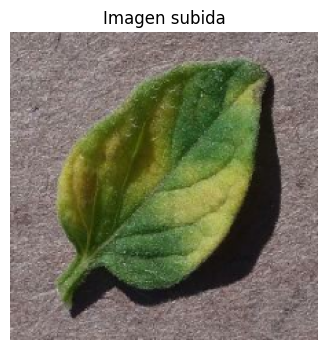

Predicción: Tomato___Leaf_Mold
Confianza (prob): 0.9899

Top 5 predicciones:
- Tomato___Leaf_Mold                             prob=0.9899
- Tomato___Late_blight                           prob=0.0039
- Tomato___Tomato_Yellow_Leaf_Curl_Virus         prob=0.0021
- Tomato___Spider_mites Two-spotted_spider_mite  prob=0.0014
- Tomato___Early_blight                          prob=0.0012


In [ ]:
# =========================
# BLOQUE 14: Subir una imagen y clasificarla con el modelo entrenado
# (Google Colab)
# =========================
from google.colab import files
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# 1) Subir imagen desde tu computador
uploaded = files.upload()

# 2) Tomar el primer archivo subido
img_path = next(iter(uploaded.keys()))
print("Imagen cargada:", img_path)

# 3) Cargar y preprocesar (MISMO tamaño que el entrenamiento)
img_bytes = tf.io.read_file(img_path)
img = tf.image.decode_image(img_bytes, channels=3, expand_animations=False)
img = tf.image.resize(img, IMG_SIZE)
img = tf.cast(img, tf.float32)  # preprocess_input se encarga del escalado/normalización según EfficientNet

# 4) Mostrar imagen
plt.figure(figsize=(4,4))
plt.imshow(tf.cast(img, tf.uint8))
plt.title("Imagen subida")
plt.axis("off")
plt.show()

# 5) Predicción (agregar batch dimension)
x = tf.expand_dims(img, axis=0)

probs = model.predict(x, verbose=0)[0]  # vector de probabilidades (num_classes,)
pred_idx = int(np.argmax(probs))
pred_class = class_names[pred_idx]
pred_conf = float(probs[pred_idx])

# 6) Mostrar resultado principal
print(f"Predicción: {pred_class}")
print(f"Confianza (prob): {pred_conf:.4f}")

# 7) Top-K predicciones
TOP_K = min(5, len(class_names))
topk_idx = np.argsort(probs)[::-1][:TOP_K]

print("\nTop", TOP_K, "predicciones:")
for i in topk_idx:
    print(f"- {class_names[int(i)]:45s}  prob={float(probs[int(i)]):.4f}")
